In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, KBinsDiscretizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# === Load data ===
train = pd.read_csv("/kaggle/input/preprocessing-2/train_processed.csv")
test  = pd.read_csv("/kaggle/input/preprocessing-2/test_processed.csv")

In [2]:
TARGET = "HotelValue"
features = [c for c in train.columns if c not in ["Id", TARGET]]

# === Separate numeric and categorical features ===
num_cols = train[features].select_dtypes(include=np.number).columns.tolist()
cat_cols = train[features].select_dtypes(exclude=np.number).columns.tolist()

# === Impute missing values ===
num_imputer = SimpleImputer(strategy='median')
train[num_cols] = num_imputer.fit_transform(train[num_cols])
test[num_cols] = num_imputer.transform(test[num_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
train[cat_cols] = cat_imputer.fit_transform(train[cat_cols])
test[cat_cols] = cat_imputer.transform(test[cat_cols])

# === Discretize numeric features into bins (non-negative) ===
n_bins = 20
kbd = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
train_num_binned = kbd.fit_transform(train[num_cols]).astype(int)
test_num_binned  = kbd.transform(test[num_cols]).astype(int)

# === Label-encode categorical features (ensure all values >=0) ===
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train_cat_encoded = encoder.fit_transform(train[cat_cols]).astype(int) + 1
test_cat_encoded  = encoder.transform(test[cat_cols]).astype(int) + 1

# === Combine numeric and categorical features ===
X_train_full = np.hstack([train_num_binned, train_cat_encoded])
X_test_full  = np.hstack([test_num_binned, test_cat_encoded])

# === Apply log-transform to target ===
train["log_target"] = np.log1p(train[TARGET])

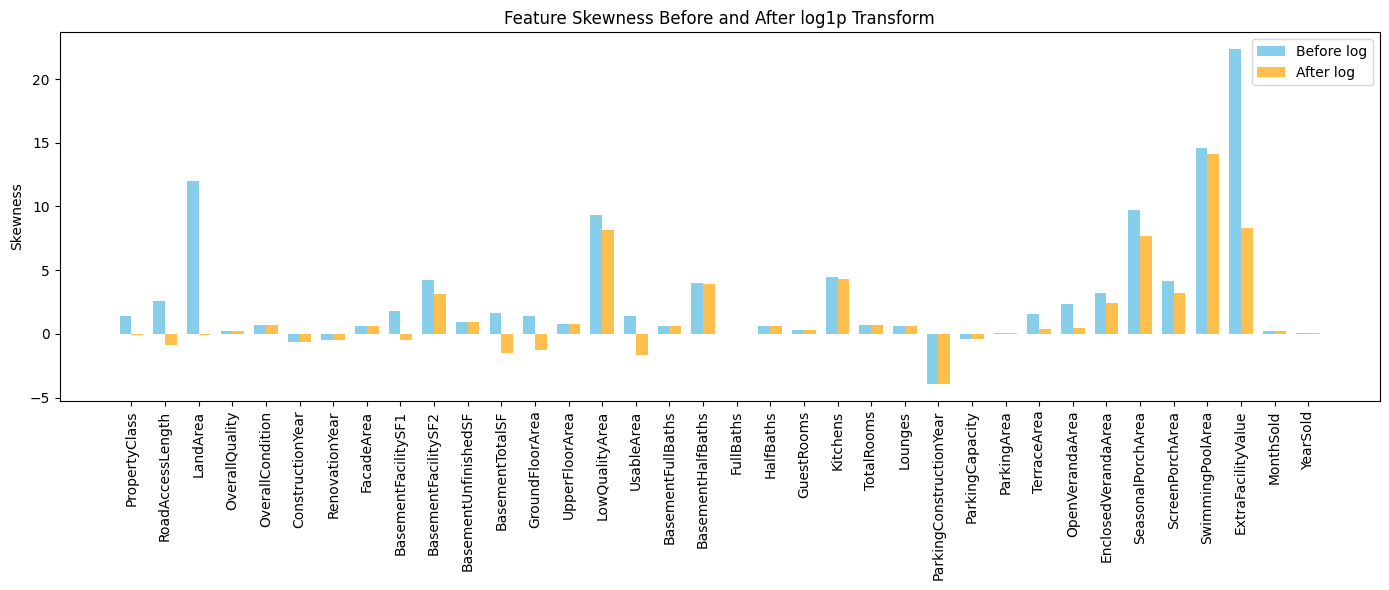

In [3]:
# === Skewness plot for numeric features ===
skew_threshold = 1.0
skewed_cols = train[num_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
skewed_cols = skewed_cols[skewed_cols > skew_threshold].index.tolist()

skew_before = train[num_cols].skew()
train_log_numeric = train[num_cols].copy()
for col in skewed_cols:
    train_log_numeric[col] = np.log1p(train_log_numeric[col])
skew_after = train_log_numeric.skew()

plt.figure(figsize=(14,6))
x = np.arange(len(num_cols))
width = 0.35
plt.bar(x - width/2, skew_before.values, width, label='Before log', color='skyblue')
plt.bar(x + width/2, skew_after.values, width, label='After log', color='orange', alpha=0.7)
plt.xticks(x, skew_before.index, rotation=90)
plt.ylabel('Skewness')
plt.title('Feature Skewness Before and After log1p Transform')
plt.legend()
plt.tight_layout()
plt.show()

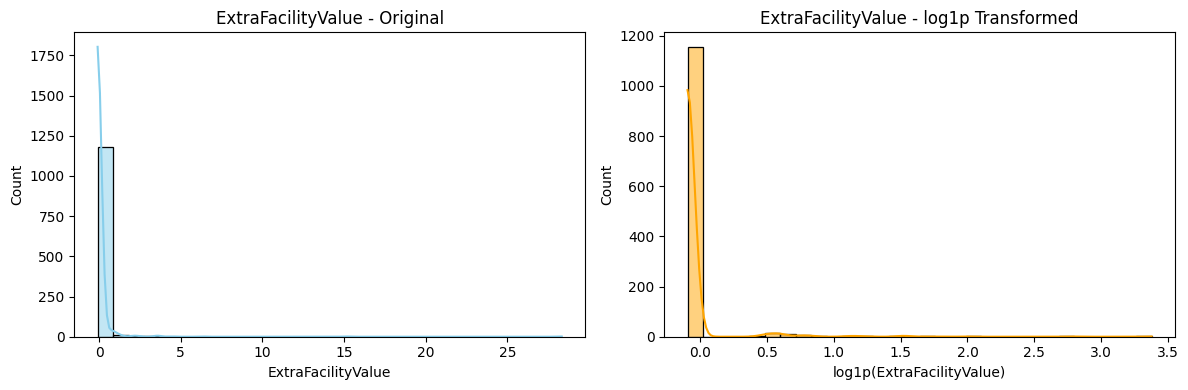

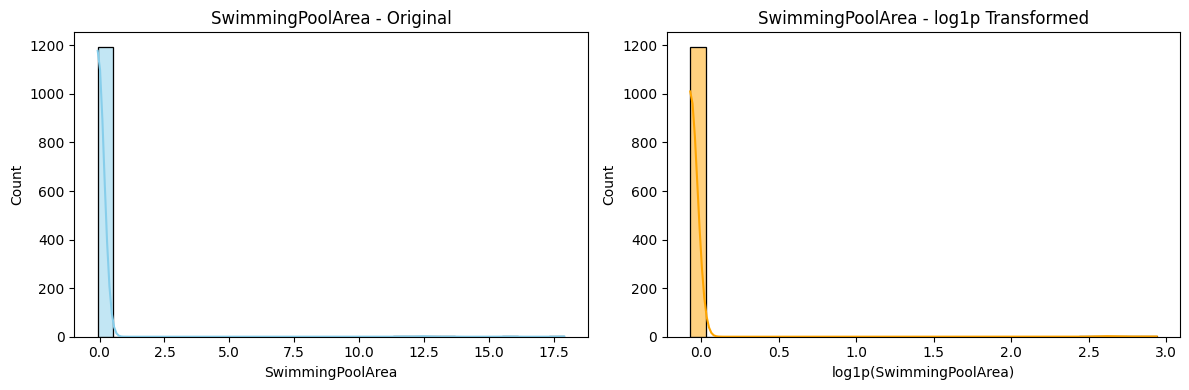

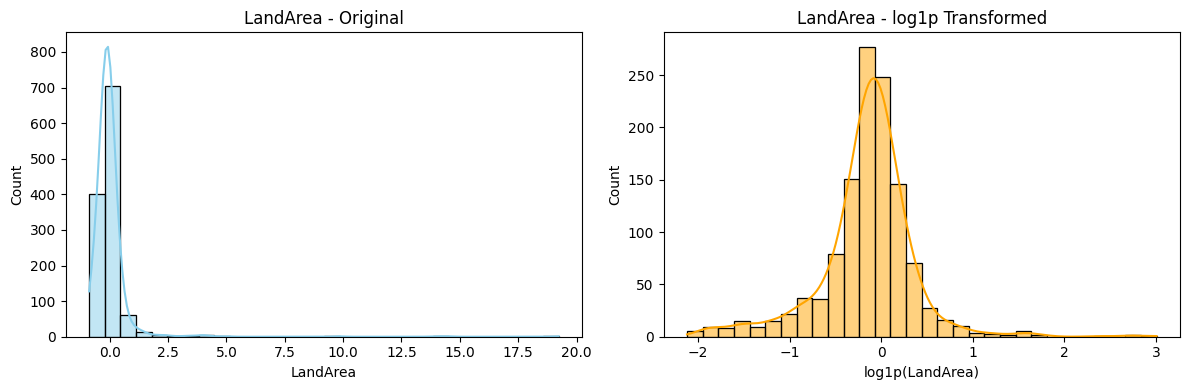

In [4]:
# Distribution plots for top 3 skewed numeric features
top_skewed = skew_before.sort_values(ascending=False).head(3).index.tolist()
for col in top_skewed:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(train[col], bins=30, kde=True, color='skyblue')
    plt.title(f'{col} - Original')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.subplot(1,2,2)
    sns.histplot(np.log1p(train[col]), bins=30, kde=True, color='orange')
    plt.title(f'{col} - log1p Transformed')
    plt.xlabel(f'log1p({col})')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

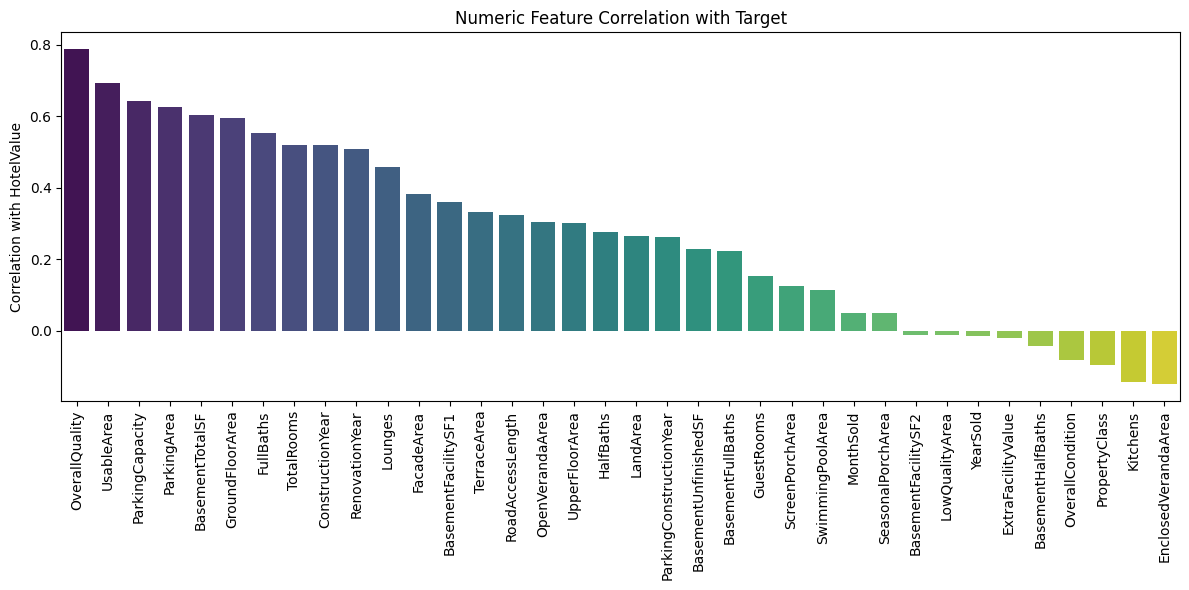

In [5]:
# Correlation with target (bar plot)
corr_with_target = train[num_cols + [TARGET]].corr()[TARGET].drop(TARGET).sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=corr_with_target.index, y=corr_with_target.values, palette='viridis')
plt.xticks(rotation=90)
plt.ylabel('Correlation with HotelValue')
plt.title('Numeric Feature Correlation with Target')
plt.tight_layout()
plt.show()

In [6]:
# === Discretize log-transformed target into bins ===
target_bins = 50
train["target_bin"] = pd.qcut(train["log_target"], q=target_bins, labels=False)
y_bins = train["target_bin"]

# === Train/validation split ===
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_bins, test_size=0.2, random_state=42)

# === Train Multinomial Naive Bayes ===
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

In [7]:
# === Predict bins on validation and test sets ===
y_val_bin_pred = mnb.predict(X_val)
y_test_bin_pred = mnb.predict(X_test_full)

# === Map predicted bins back to log-target midpoints ===
bin_edges = pd.qcut(train["log_target"], q=target_bins, retbins=True)[1]
y_val_log_pred = np.array([(bin_edges[b] + bin_edges[b+1])/2 for b in y_val_bin_pred])
y_test_log_pred = np.array([(bin_edges[b] + bin_edges[b+1])/2 for b in y_test_bin_pred])

# === Convert predictions back to original target scale ===
y_val_pred = np.expm1(y_val_log_pred)
y_test_pred = np.expm1(y_test_log_pred)

# === Evaluate RMSE on validation set ===
val_rmse = mean_squared_error(y_val_pred, train.loc[y_val.index, TARGET], squared=False)
print(f"Validation RMSE (log-transform): {val_rmse:.2f}")

Validation RMSE (log-transform): 50211.47


In [8]:
bin_edges_old = pd.qcut(train[TARGET], q=target_bins, retbins=True)[1]

# Predict bins using the same trained model (mnb)
# Note: The model was trained on log bins, so to get an accurate comparison,
# you need to re-train briefly on the original (non-log) target bins.

train["target_bin_old"] = pd.qcut(train[TARGET], q=target_bins, labels=False)
y_bins_old = train["target_bin_old"]

# Train a new MNB for fair comparison
X_train_old, X_val_old, y_train_old, y_val_old = train_test_split(
    X_train_full, y_bins_old, test_size=0.2, random_state=42
)
mnb_old = MultinomialNB()
mnb_old.fit(X_train_old, y_train_old)

# Predict bins on validation set
y_val_bin_pred_old = mnb_old.predict(X_val_old)

# Map predicted bins back to continuous values
y_val_pred_old = np.array([(bin_edges_old[b] + bin_edges_old[b+1])/2 for b in y_val_bin_pred_old])

# Compute RMSE in original scale
val_rmse_old = mean_squared_error(y_val_pred_old, train.loc[y_val_old.index, TARGET], squared=False)
print(f"Validation RMSE (no log-transform): {val_rmse_old:.2f}")

Validation RMSE (no log-transform): 50464.34


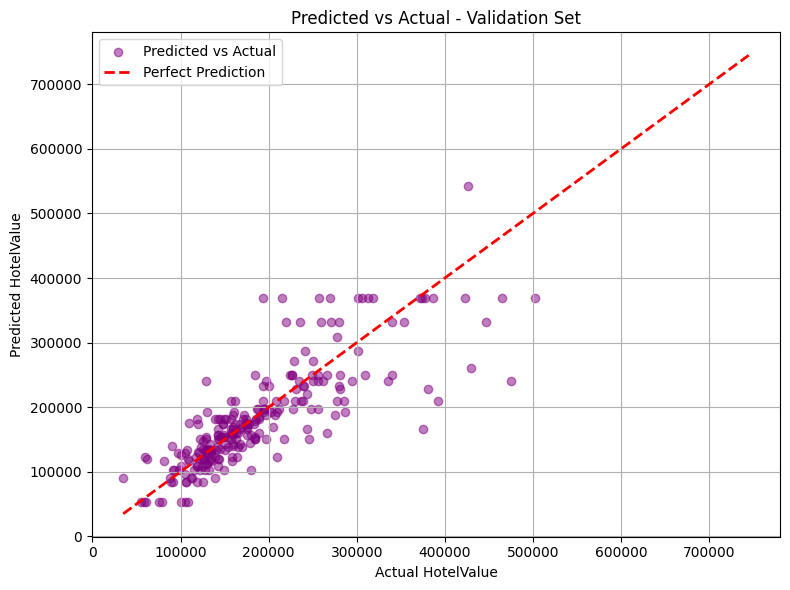

In [9]:
# === Predicted vs Actual plot ===
plt.figure(figsize=(8,6))
plt.scatter(train.loc[y_val.index, TARGET], y_val_pred, alpha=0.5, color='purple', label='Predicted vs Actual')
plt.plot([train[TARGET].min(), train[TARGET].max()], [train[TARGET].min(), train[TARGET].max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel("Actual HotelValue")
plt.ylabel("Predicted HotelValue")
plt.title("Predicted vs Actual - Validation Set")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

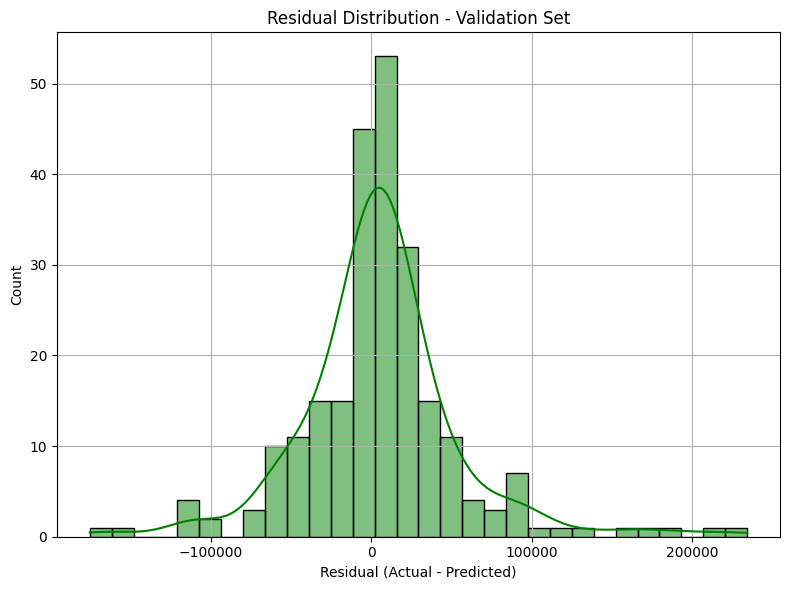

In [10]:
# Residual plot
residuals = train.loc[y_val.index, TARGET] - y_val_pred
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=30, kde=True, color='green')
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.title("Residual Distribution - Validation Set")
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# === Create submission ===
submission = pd.DataFrame({"Id": test["Id"], "HotelValue": y_test_pred})
submission.to_csv("submission.csv", index=False)
print("Submission file 'submission.csv' created successfully!")

Submission file 'submission.csv' created successfully!
